Shape train_features_mom: (331, 3, 5)
Shape test_features_mom: (12, 3, 5)
Shape train_features_yoy: (331, 3, 5)
Shape test_features_yoy: (12, 3, 5)
Chạy mô hình LSTM cho CPI MoM với args: [array([[0.19082569],
       [0.15412844],
       [0.20917431],
       [0.33761468],
       [0.30091743],
       [0.44770642],
       [0.46605505],
       [0.4293578 ],
       [0.61284404],
       [0.19082569],
       [0.17247706],
       [0.19082569],
       [0.30091743],
       [0.31926606],
       [0.30091743],
       [0.39266055],
       [0.33761468],
       [0.33761468],
       [0.46605505],
       [0.57614679],
       [0.68623853],
       [0.13577982],
       [0.57614679],
       [0.53944954],
       [0.28256881],
       [0.19082569],
       [0.48440367],
       [0.46605505],
       [0.33761468],
       [0.30091743],
       [0.4293578 ],
       [0.59449541],
       [0.63119266],
       [0.15412844],
       [0.17247706],
       [0.20917431],
       [0.22752294],
       [0.20917431],
       [0.209

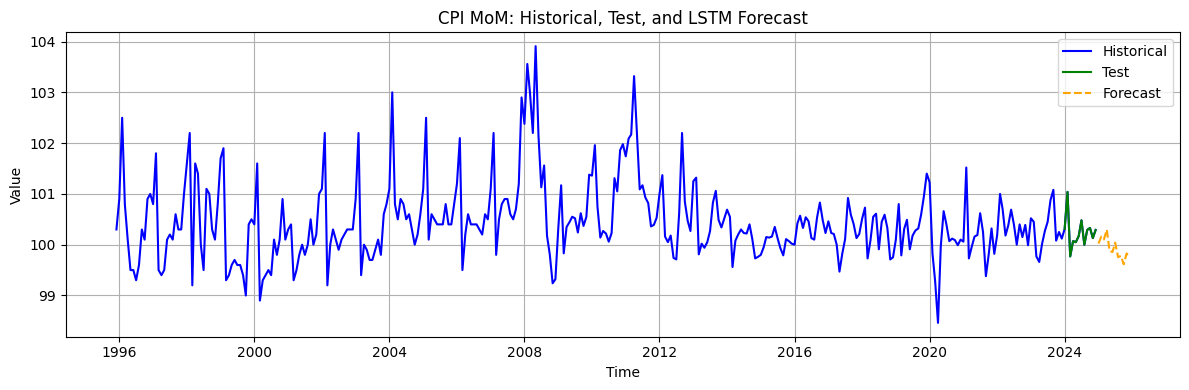

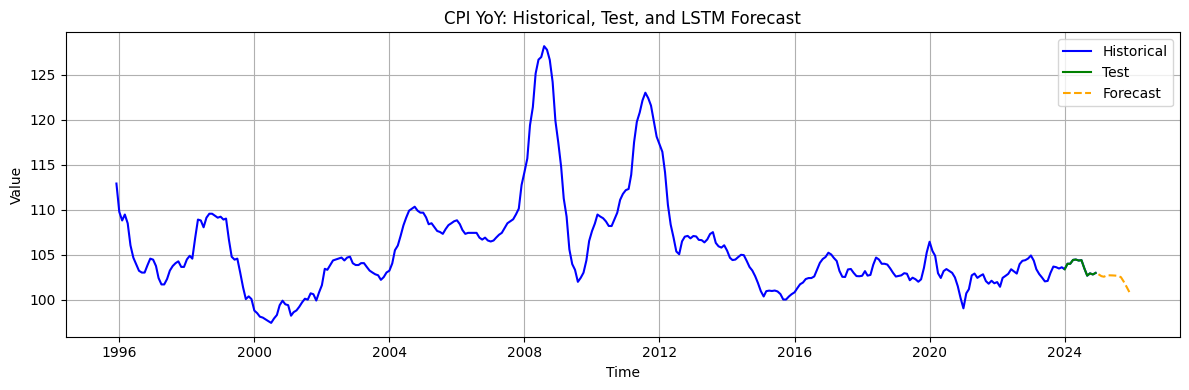

<Figure size 500x300 with 0 Axes>

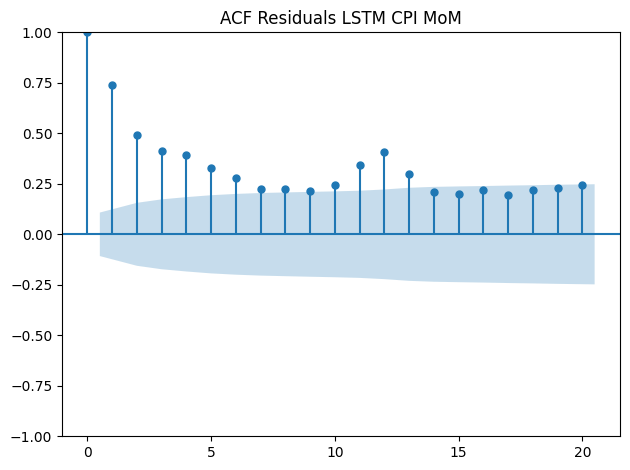

<Figure size 500x300 with 0 Axes>

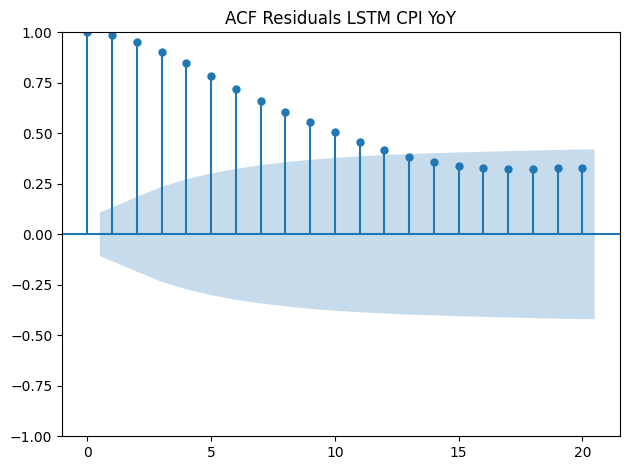

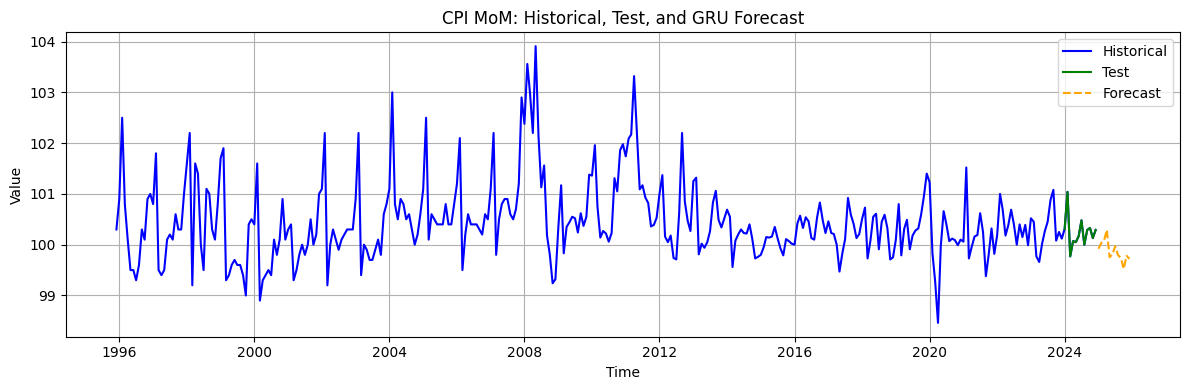

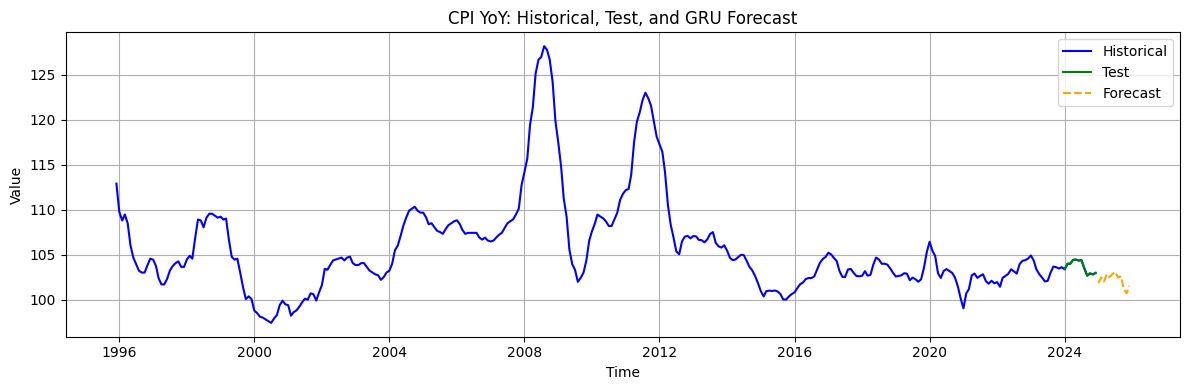

<Figure size 500x300 with 0 Axes>

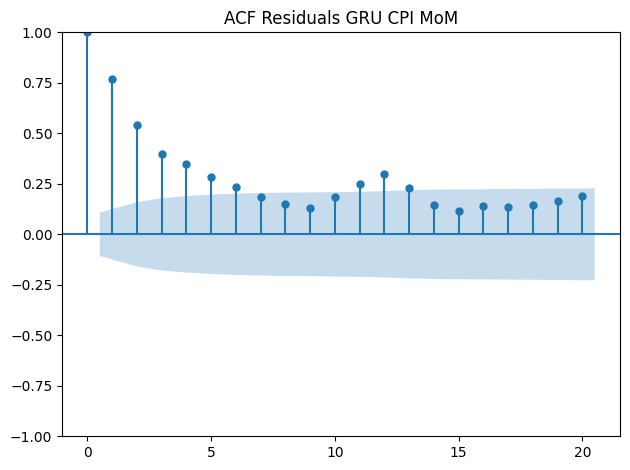

<Figure size 500x300 with 0 Axes>

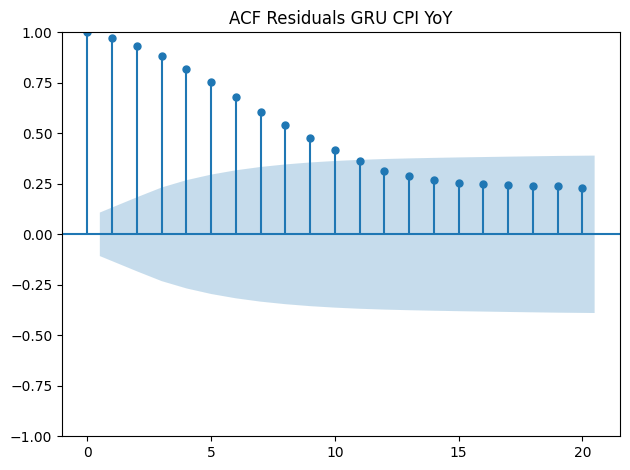

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import os
import itertools
warnings.filterwarnings("ignore")

# Hàm tính toán các chỉ số đánh giá
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(((predicted - actual) ** 2).mean())
    mae = np.mean(np.abs(predicted - actual))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    return rmse, mae, mape

# Hàm trực quan hóa dự báo
def plot_forecast(historical, test, forecast, forecast_index, title, ylabel, filename, confidence_intervals=None):
    plt.figure(figsize=(12, 4))
    plt.plot(historical.index, historical, label='Historical', color='blue')
    plt.plot(test.index, test, label='Test', color='green')
    plt.plot(forecast_index, forecast, label='Forecast', color='orange', linestyle='--')
    if confidence_intervals is not None:
        plt.fill_between(forecast_index, confidence_intervals[0], confidence_intervals[1], 
                         color='orange', alpha=0.2, label='Confidence Interval')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    # plt.close()

# Hàm trực quan hóa ACF phần dư
def plot_residual_acf(residuals, title, filename):
    if residuals is None or len(residuals) < 2:
        print(f"Bỏ qua ACF: phần dư quá ngắn hoặc không hợp lệ - {title}")
        return
        
    residuals = np.ravel(residuals)  # Đảm bảo residuals là 1D
    plt.figure(figsize=(5, 3))
    plot_acf(residuals, lags=20, title=title)
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    # plt.close()


# Hàm tạo đặc trưng cho mô hình học sâu
def create_dl_features(df, target_col, exog_cols, lags=[1, 2, 3], timesteps=3):
    data = df.copy()
    # Tạo đặc trưng trễ
    for lag in lags:
        data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)
    # Thêm các cột ngoại sinh
    features = data[[f'{target_col}_lag_{lag}' for lag in lags] + exog_cols].dropna()
    target = data[target_col].loc[features.index]
    
    # Chuẩn hóa dữ liệu
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))
    
    # Tạo dữ liệu dạng chuỗi cho LSTM/GRU
    X, y = [], []
    for i in range(len(features_scaled) - timesteps):
        X.append(features_scaled[i:i + timesteps])
        y.append(target_scaled[i + timesteps])
    X, y = np.array(X), np.array(y)
    
    return X, y, scaler_features, scaler_target, features.index[timesteps:]

# Hàm chạy LSTM
def run_lstm(train, test, exog_train, exog_test, forecast_index, param_grid=None, scaler_target=None):
    best_rmse = float('inf')
    best_model = None
    best_forecast = None
    best_residuals = None
    mae = mape = None

    if param_grid:
        print("Tối ưu tham số cho LSTM...")
        param_combinations = list(itertools.product(
            param_grid['units'], param_grid['layers'], param_grid['learning_rate']
        ))

        for units, layers, lr in param_combinations:
            try:
                model = Sequential()
                model.add(LSTM(units=units, return_sequences=(layers > 1), input_shape=(exog_train.shape[1], exog_train.shape[2])))
                for _ in range(layers - 1):
                    model.add(LSTM(units=units, return_sequences=(_ < layers - 2)))
                model.add(Dense(1))
                model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

                model.fit(exog_train, train, epochs=50, batch_size=32, verbose=0)
                forecast_scaled = model.predict(exog_test, verbose=0)
                forecast = scaler_target.inverse_transform(forecast_scaled).flatten()
                rmse, tmp_mae, tmp_mape = calculate_metrics(test, forecast)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_forecast = forecast
                    best_residuals = train.flatten() - scaler_target.inverse_transform(
                        model.predict(exog_train, verbose=0)
                    ).flatten()
                    mae, mape = tmp_mae, tmp_mape
                    print(f"RMSE tốt hơn: {best_rmse:.4f} với units={units}, layers={layers}, lr={lr}")

            except Exception as e:
                print(f"Lỗi với units={units}, layers={layers}, lr={lr}: {str(e)}")
                continue
    else:
        model = Sequential()
        model.add(LSTM(units=64, input_shape=(exog_train.shape[1], exog_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model.fit(exog_train, train, epochs=50, batch_size=32, verbose=0)
        forecast_scaled = model.predict(exog_test, verbose=0)
        best_forecast = scaler_target.inverse_transform(forecast_scaled).flatten()
        best_residuals = train.flatten() - scaler_target.inverse_transform(
            model.predict(exog_train, verbose=0)
        ).flatten()
        best_rmse, mae, mape = calculate_metrics(test, best_forecast)

    return pd.Series(best_forecast, index=forecast_index), best_residuals, best_rmse, mae, mape

# Hàm chạy GRU
def run_gru(train, test, exog_train, exog_test, forecast_index, param_grid=None, scaler_target=None):
    best_rmse = float('inf')
    best_model = None
    best_forecast = None
    best_residuals = None
    mae = mape = None

    if param_grid:
        print("Tối ưu tham số cho GRU...")
        param_combinations = list(itertools.product(
            param_grid['units'], param_grid['layers'], param_grid['learning_rate']
        ))

        for units, layers, lr in param_combinations:
            try:
                model = Sequential()
                model.add(GRU(units=units, return_sequences=(layers > 1), input_shape=(exog_train.shape[1], exog_train.shape[2])))
                for _ in range(layers - 1):
                    model.add(GRU(units=units, return_sequences=(_ < layers - 2)))
                model.add(Dense(1))
                model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

                model.fit(exog_train, train, epochs=50, batch_size=32, verbose=0)
                forecast_scaled = model.predict(exog_test, verbose=0)
                forecast = scaler_target.inverse_transform(forecast_scaled).flatten()
                rmse, tmp_mae, tmp_mape = calculate_metrics(test, forecast)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_forecast = forecast
                    best_residuals = train.flatten() - scaler_target.inverse_transform(
                        model.predict(exog_train, verbose=0)
                    ).flatten()
                    mae, mape = tmp_mae, tmp_mape
                    print(f"RMSE tốt hơn: {best_rmse:.4f} với units={units}, layers={layers}, lr={lr}")

            except Exception as e:
                print(f"Lỗi với units={units}, layers={layers}, lr={lr}: {str(e)}")
                continue
    else:
        model = Sequential()
        model.add(GRU(units=64, input_shape=(exog_train.shape[1], exog_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model.fit(exog_train, train, epochs=50, batch_size=32, verbose=0)
        forecast_scaled = model.predict(exog_test, verbose=0)
        best_forecast = scaler_target.inverse_transform(forecast_scaled).flatten()
        best_residuals = train.flatten() - scaler_target.inverse_transform(
            model.predict(exog_train, verbose=0)
        ).flatten()
        best_rmse, mae, mape = calculate_metrics(test, best_forecast)

    return pd.Series(best_forecast, index=forecast_index), best_residuals, best_rmse, mae, mape

# Main execution
if __name__ == "__main__":
    # Tạo thư mục img
    if not os.path.exists('img'):
        os.makedirs('img')
    
    # Đọc dữ liệu
    file_path = "data/analyzed_time_series.csv"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} không tồn tại!")
    
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='coerce')
    
    if df['time'].isna().any():
        print("Cảnh báo: Có giá trị thời gian không hợp lệ!")
        df = df.dropna(subset=['time'])
    
    df = df.sort_values(by='time')
    df.set_index('time', inplace=True)
    
    # Kiểm tra cột cần thiết
    required_columns = ['cpi_mom', 'cpi_yoy', 'oil_price', 'gold_price', 'interest_rate']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Thiếu một hoặc nhiều cột cần thiết trong dữ liệu!")
    
    # Kiểm tra độ dài dữ liệu
    if len(df) < 24:
        raise ValueError("Dữ liệu quá ngắn, cần ít nhất 24 tháng!")
    
    # Chia tập train/test
    train_mom, test_mom = df['cpi_mom'][:-12], df['cpi_mom'][-12:]
    train_yoy, test_yoy = df['cpi_yoy'][:-12], df['cpi_yoy'][-12:]
    
    # Tạo đặc trưng cho mô hình học sâu
    lags = [1, 2, 3]
    timesteps = 3
    mom_features, mom_target, mom_scaler_features, mom_scaler_target, mom_index = create_dl_features(
        df, 'cpi_mom', ['oil_price', 'gold_price'], lags, timesteps
    )
    yoy_features, yoy_target, yoy_scaler_features, yoy_scaler_target, yoy_index = create_dl_features(
        df, 'cpi_yoy', ['oil_price', 'gold_price'], lags, timesteps
    )
    
    # Chia đặc trưng train/test
    train_idx_mom = mom_index[:-12]
    test_idx_mom = mom_index[-12:]
    train_features_mom = mom_features[:len(train_idx_mom)]
    test_features_mom = mom_features[len(train_idx_mom):]
    train_target_mom = mom_target[:len(train_idx_mom)]
    test_target_mom = mom_target[len(train_idx_mom):]
    
    train_idx_yoy = yoy_index[:-12]
    test_idx_yoy = yoy_index[-12:]
    train_features_yoy = yoy_features[:len(train_idx_yoy)]
    test_features_yoy = yoy_features[len(train_idx_yoy):]
    train_target_yoy = yoy_target[:len(train_idx_yoy)]
    test_target_yoy = yoy_target[len(train_idx_yoy):]
    
    # Kiểm tra đặc trưng
    print("Shape train_features_mom:", train_features_mom.shape)
    print("Shape test_features_mom:", test_features_mom.shape)
    print("Shape train_features_yoy:", train_features_yoy.shape)
    print("Shape test_features_yoy:", test_features_yoy.shape)
    
    # Tạo chỉ mục dự báo
    last_date = df.index[-1].to_period('M').to_timestamp()
    forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
    
    # Định nghĩa lưới tham số cho mô hình học sâu
    dl_param_grid = {
        'units': [16, 32, 64],
        'layers': [1, 2, 3],
        'learning_rate': [0.0001, 0.001, 0.01]
    }
    
    # Danh sách mô hình và tham số
    models = [
        ('LSTM', run_lstm, {'mom': {'param_grid': dl_param_grid, 'scaler_target': mom_scaler_target}, 
                            'yoy': {'param_grid': dl_param_grid, 'scaler_target': yoy_scaler_target}}),
        ('GRU', run_gru, {'mom': {'param_grid': dl_param_grid, 'scaler_target': mom_scaler_target}, 
                  'yoy': {'param_grid': dl_param_grid, 'scaler_target': yoy_scaler_target}})
    ]
    
    # Chạy từng mô hình và lưu kết quả
    results = {'mom': {}, 'yoy': {}}
    for model_name, model_func, params in models:
        # CPI MoM
        args = [train_target_mom, test_target_mom, train_features_mom, test_features_mom, test_mom.index]
        print(f"Chạy mô hình {model_name} cho CPI MoM với args: {args[:5]}")
        forecast, residuals, rmse, mae, mape = model_func(*args, 
                                                  param_grid=params['mom']['param_grid'], 
                                                  scaler_target=params['mom']['scaler_target'])
        results['mom'][model_name] = {'forecast': forecast, 'residuals': residuals, 
                                     'rmse': rmse, 'mae': mae, 'mape': mape}
        
        # CPI YoY
        args = [train_target_yoy, test_target_yoy, train_features_yoy, test_features_yoy, test_yoy.index]
        print(f"Chạy mô hình {model_name} cho CPI YoY với args: {args[:5]}")
        forecast, residuals, rmse, mae, mape = model_func(*args, 
                                                  param_grid=params['yoy']['param_grid'], 
                                                  scaler_target=params['yoy']['scaler_target'])
        results['yoy'][model_name] = {'forecast': forecast, 'residuals': residuals, 
                                     'rmse': rmse, 'mae': mae, 'mape': mape}
        
        # Trực quan hóa
        plot_forecast(df['cpi_mom'], test_mom, results['mom'][model_name]['forecast'], forecast_index,
                      f'CPI MoM: Historical, Test, and {model_name} Forecast', 'Value',
                      f'cpi_mom_{model_name.lower().replace(" ", "_")}_forecast.png')
        plot_forecast(df['cpi_yoy'], test_yoy, results['yoy'][model_name]['forecast'], forecast_index,
                      f'CPI YoY: Historical, Test, and {model_name} Forecast', 'Value',
                      f'cpi_yoy_{model_name.lower().replace(" ", "_")}_forecast.png')
        
        # ACF phần dư
        plot_residual_acf(results['mom'][model_name]['residuals'], f'ACF Residuals {model_name} CPI MoM',
                          f'residual_acf_{model_name.lower().replace(" ", "_")}_mom.png')
        plot_residual_acf(results['yoy'][model_name]['residuals'], f'ACF Residuals {model_name} CPI YoY',
                          f'residual_acf_{model_name.lower().replace(" ", "_")}_yoy.png')
    
    # In kết quả
    for metric in ['rmse', 'mae', 'mape']:
        print(f"\n{metric.upper()} Results:")
        for model_name in results['mom']:
            print(f"{model_name} CPI MoM: {results['mom'][model_name][metric]:.4f}")
            print(f"{model_name} CPI YoY: {results['yoy'][model_name][metric]:.4f}")

2025-05-07 11:47:15,370 - WARNING - Phát hiện giá trị ngoại lai trong cpi_mom, thay thế bằng trung vị...
2025-05-07 11:47:15,375 - WARNING - Phát hiện giá trị ngoại lai trong cpi_yoy, thay thế bằng trung vị...
2025-05-07 11:47:15,454 - INFO - ADF Test for cpi_mom: Statistic=-3.1009, p-value=0.0265
2025-05-07 11:47:15,483 - INFO - ADF Test for cpi_yoy: Statistic=-2.5688, p-value=0.0996
2025-05-07 11:47:15,484 - WARNING - Chuỗi cpi_yoy không dừng, thực hiện lấy sai phân...
2025-05-07 11:47:15,493 - INFO - Xử lý cpi_mom...
2025-05-07 11:47:15,507 - INFO - Shape X_train (cpi_mom): (330, 3, 6), X_test: (12, 3, 6)
2025-05-07 11:47:15,508 - INFO - Chạy mô hình LSTM cho cpi_mom...
2025-05-07 11:47:15,508 - INFO - Tối ưu tham số cho LSTM (cpi_mom)...
2025-05-07 11:47:15,509 - INFO - Thử LSTM với units=16, layers=2, lr=0.1
2025-05-07 11:47:16,315 - INFO - Input shape for LSTM: (330, 3, 6)
2025-05-07 11:47:26,618 - INFO - RMSE tốt hơn: 0.3072 với units=16, layers=2, lr=0.1
2025-05-07 11:47:26,619

<Figure size 500x300 with 0 Axes>

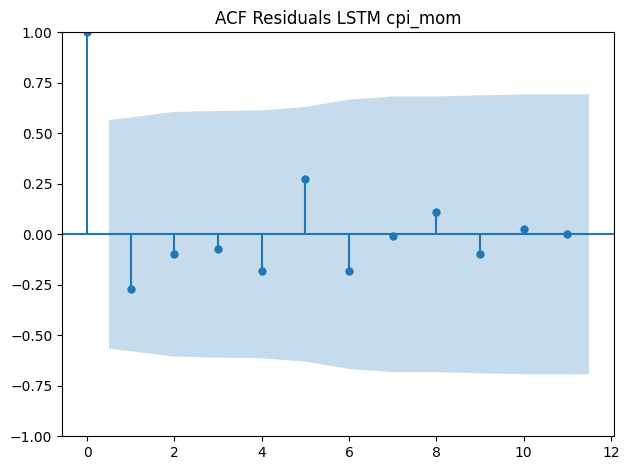

<Figure size 500x300 with 0 Axes>

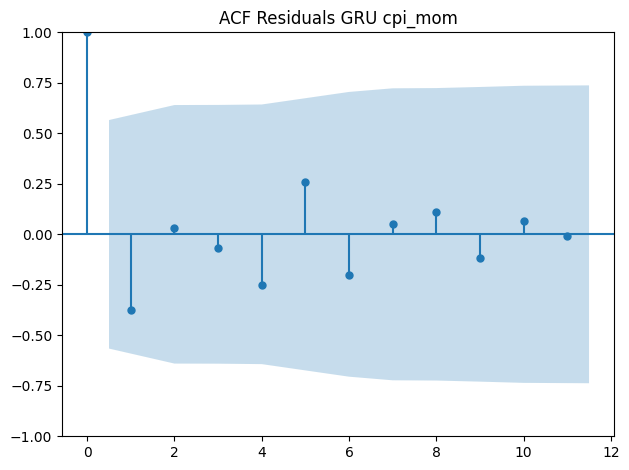

<Figure size 500x300 with 0 Axes>

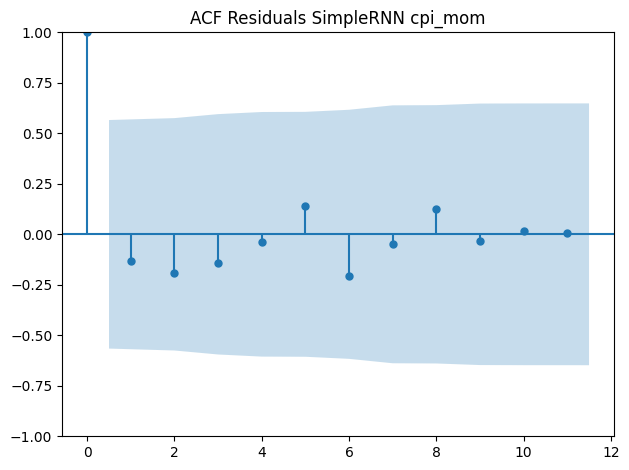

<Figure size 500x300 with 0 Axes>

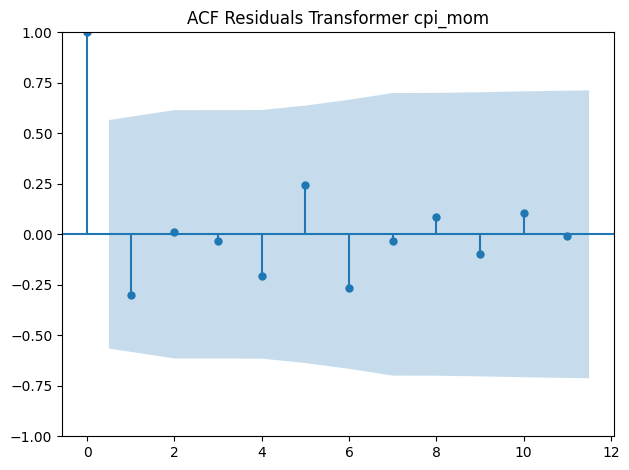

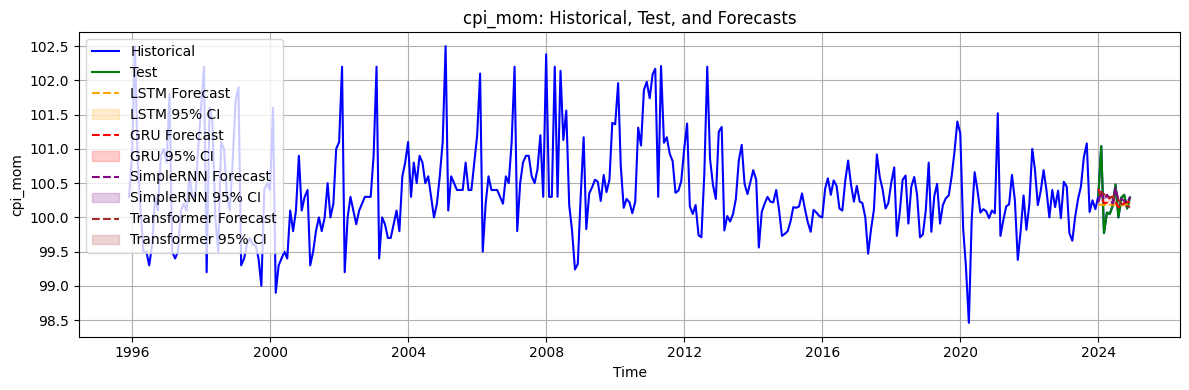

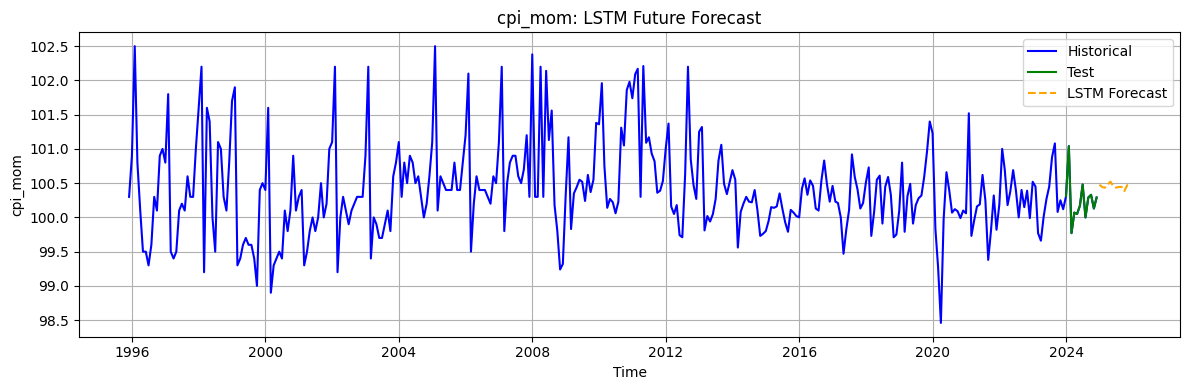

<Figure size 500x300 with 0 Axes>

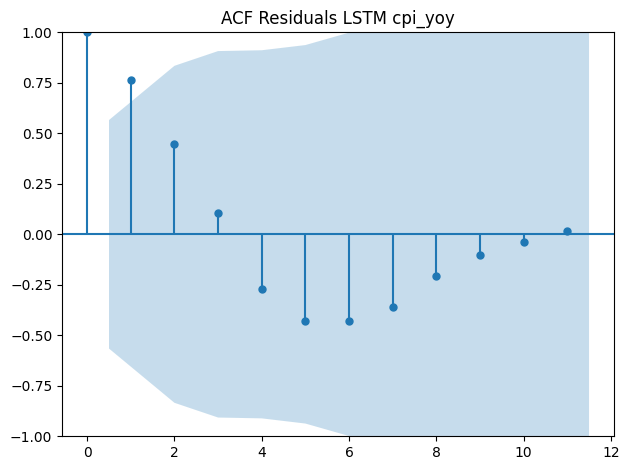

<Figure size 500x300 with 0 Axes>

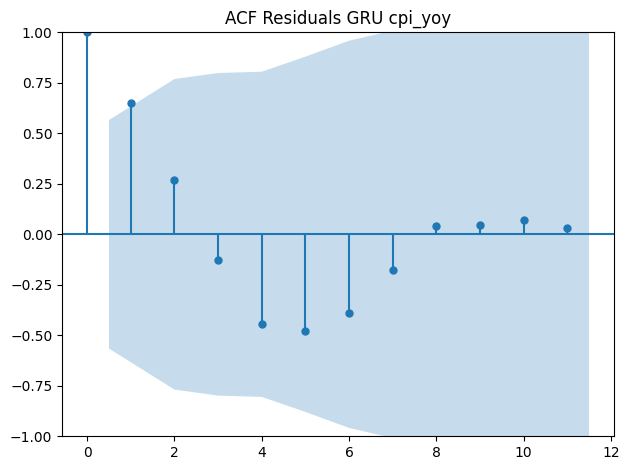

<Figure size 500x300 with 0 Axes>

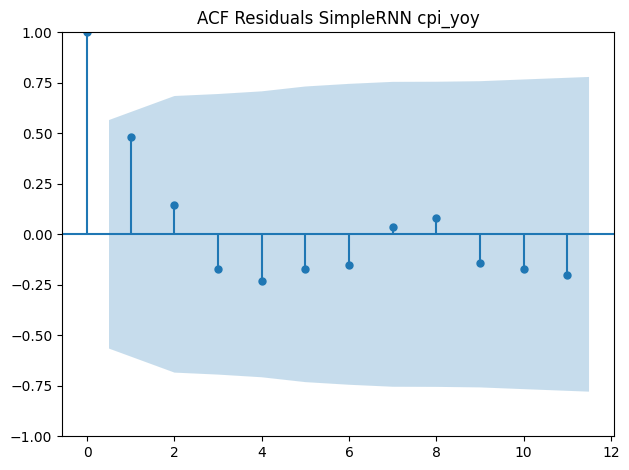

<Figure size 500x300 with 0 Axes>

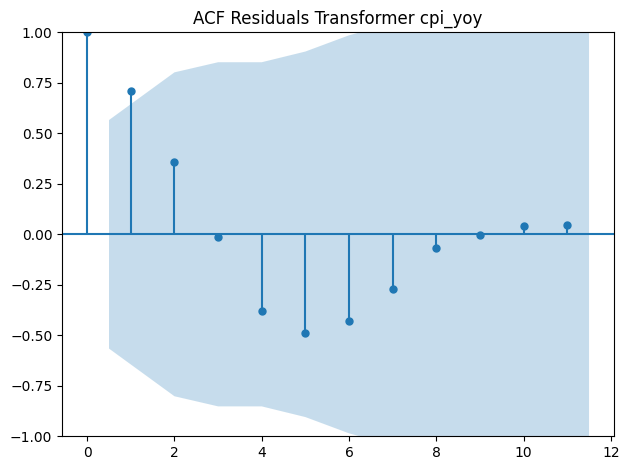

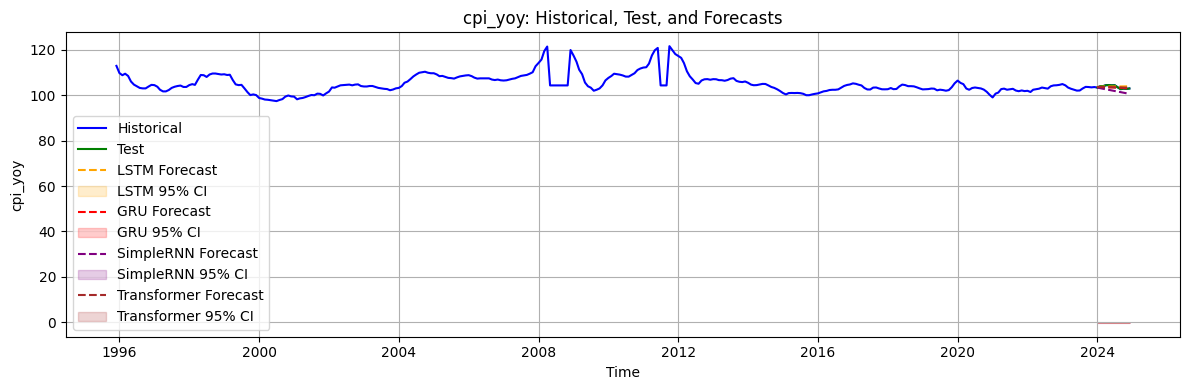

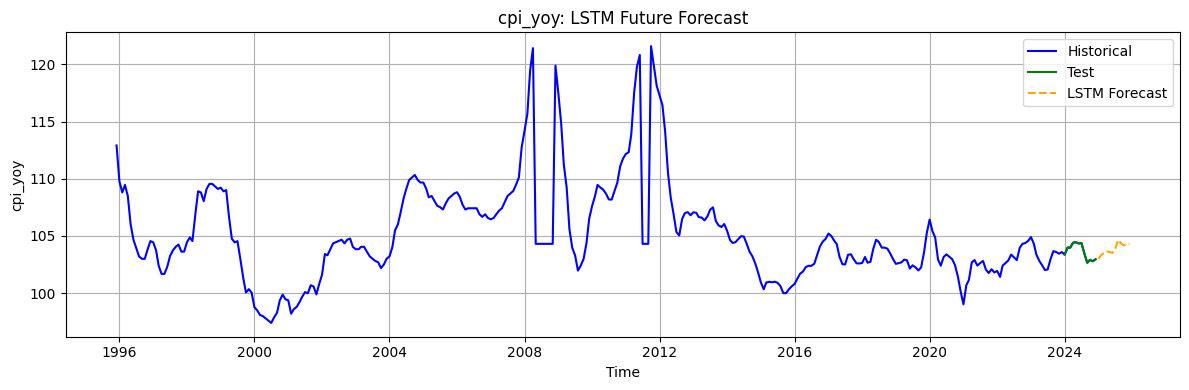

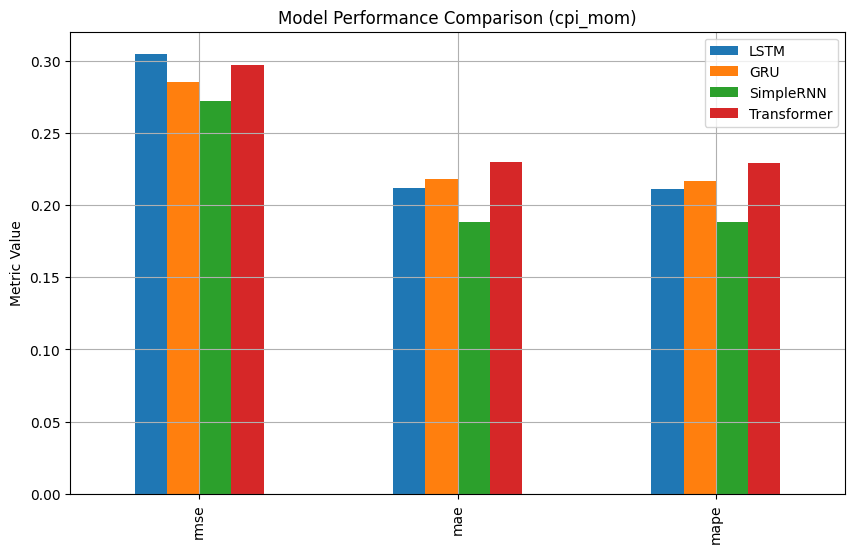

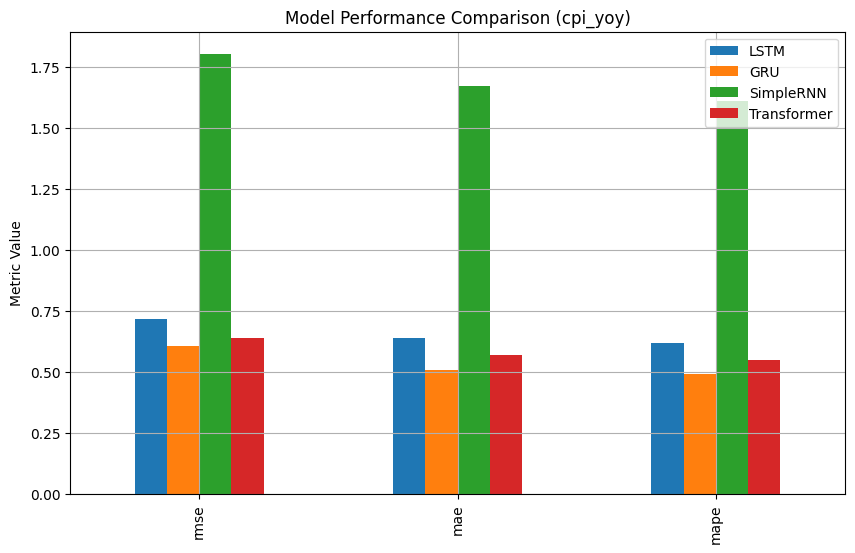

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, LayerNormalization, MultiHeadAttention, Input, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import os
import itertools
import logging
import random
from datetime import datetime
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Thiết lập logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Tạo thư mục lưu trữ
os.makedirs('img', exist_ok=True)
os.makedirs('models', exist_ok=True)

class CPIForecaster:
    def __init__(self, data_path, target_cols=['cpi_mom', 'cpi_yoy'], exog_cols=None, lags=[1, 2, 3], timesteps=3):
        self.data_path = data_path
        self.target_cols = target_cols
        self.exog_cols = exog_cols if exog_cols else []
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.results = {col: {} for col in target_cols}
        self.scalers = {col: {'features': None, 'target': None} for col in target_cols}
        self.stationary = {col: False for col in target_cols}
        self.original_values = {col: None for col in target_cols}

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path)
            self.df['time'] = pd.to_datetime(self.df['time'], format='%Y-%m-%d', errors='coerce')
            if self.df['time'].isna().any():
                logger.warning("Có giá trị thời gian không hợp lệ, loại bỏ...")
                self.df = self.df.dropna(subset=['time'])
            self.df = self.df.sort_values(by='time').set_index('time')
            required_columns = self.target_cols + self.exog_cols
            if not all(col in self.df.columns for col in required_columns):
                raise ValueError(f"Thiếu cột: {required_columns}")
            if len(self.df) < 24:
                raise ValueError("Dữ liệu quá ngắn, cần ít nhất 24 tháng!")
            
            for col in self.target_cols + self.exog_cols:
                z_scores = np.abs((self.df[col] - self.df[col].mean()) / self.df[col].std())
                if (z_scores > 3).any():
                    logger.warning(f"Phát hiện giá trị ngoại lai trong {col}, thay thế bằng trung vị...")
                    self.df.loc[z_scores > 3, col] = self.df[col].median()

            for col in self.target_cols:
                result = adfuller(self.df[col])
                logger.info(f"ADF Test for {col}: Statistic={result[0]:.4f}, p-value={result[1]:.4f}")
                if result[1] > 0.05:
                    logger.warning(f"Chuỗi {col} không dừng, thực hiện lấy sai phân...")
                    self.original_values[col] = self.df[col].copy()
                    self.df[col] = self.df[col].diff().dropna()
                    self.stationary[col] = False
                else:
                    self.stationary[col] = True
        except Exception as e:
            logger.error(f"Lỗi khi đọc dữ liệu: {str(e)}")
            raise

    def create_features(self, target_col):
        data = self.df.copy()
        for lag in self.lags:
            data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)
        features = data[[f'{target_col}_lag_{lag}' for lag in self.lags] + self.exog_cols].dropna()
        target = data[target_col].loc[features.index]

        scaler_features = MinMaxScaler()
        scaler_target = MinMaxScaler()
        features_scaled = scaler_features.fit_transform(features)
        target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

        X, y = [], []
        for i in range(len(features_scaled) - self.timesteps):
            X.append(features_scaled[i:i + self.timesteps])
            y.append(target_scaled[i + self.timesteps])
        X, y = np.array(X), np.array(y)

        self.scalers[target_col]['features'] = scaler_features
        self.scalers[target_col]['target'] = scaler_target
        return X, y, features.index[self.timesteps:]

    def split_data(self, target_col, test_size=12):
        X, y, index = self.create_features(target_col)
        train_idx = index[:-test_size]
        test_idx = index[-test_size:]
        X_train, X_test = X[:len(train_idx)], X[len(train_idx):]
        y_train, y_test = y[:len(train_idx)], y[len(train_idx):]
        logger.info(f"Shape X_train ({target_col}): {X_train.shape}, X_test: {X_test.shape}")
        return X_train, X_test, y_train, y_test, train_idx, test_idx

    def calculate_metrics(self, actual, predicted):
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((predicted - actual) / (actual + 1e-8))) * 100
        return rmse, mae, mape

    def plot_forecast(self, historical, test, forecasts, forecast_index, title, ylabel, filename, confidence_intervals=None):
        plt.figure(figsize=(12, 4))
        plt.plot(historical.index, historical, label='Historical', color='blue')
        plt.plot(test.index, test, label='Test', color='green')
        colors = ['orange', 'red', 'purple', 'brown']
        valid_forecasts = {k: v for k, v in forecasts.items() if v is not None}
        if not valid_forecasts:
            logger.warning(f"Không có dự báo hợp lệ để vẽ cho {title}")
            # plt.close()
            return
        for i, (model_name, forecast) in enumerate(valid_forecasts.items()):
            plt.plot(forecast_index, forecast, label=f'{model_name} Forecast', color=colors[i % len(colors)], linestyle='--')
            if confidence_intervals and model_name in confidence_intervals and confidence_intervals[model_name] is not None:
                plt.fill_between(forecast_index, confidence_intervals[model_name][0], confidence_intervals[model_name][1],
                                 color=colors[i % len(colors)], alpha=0.2, label=f'{model_name} 95% CI')
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'img/{filename}')
        # plt.close()

    def plot_residual_acf(self, residuals, title, filename):
        if residuals is None or len(residuals) < 2:
            logger.warning(f"Bỏ qua ACF: phần dư không hợp lệ - {title}")
            return
        residuals = np.ravel(residuals)
        logger.info(f"Residuals shape for {title}: {residuals.shape}")
        max_lags = min(20, len(residuals) - 1)
        if max_lags < 1:
            logger.warning(f"Bỏ qua ACF: quá ít residuals để tính toán - {title}")
            return
        plt.figure(figsize=(5, 3))
        plot_acf(residuals, lags=max_lags, title=title)
        plt.tight_layout()
        plt.savefig(f'img/{filename}')
        # plt.close()

    def transformer_model(self, input_shape, units, num_heads=4):
        inputs = Input(shape=input_shape)
        x = MultiHeadAttention(num_heads=num_heads, key_dim=units)(inputs, inputs)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dense(units, activation='relu')(x)
        x = TimeDistributed(Dense(1))(x)  # Ensure output per timestep
        x = Dense(1)(x[:, -1, :])  # Take the last timestep
        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def calculate_confidence_intervals(self, model, X_test, target_col, n_iterations=30):
        predictions = []
        for _ in range(n_iterations):
            pred_scaled = model.predict(X_test, verbose=0)
            pred = self.scalers[target_col]['target'].inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
            predictions.append(pred)
        predictions = np.array(predictions)
        lower = np.percentile(predictions, 2.5, axis=0)
        upper = np.percentile(predictions, 97.5, axis=0)
        return lower, upper

    def run_model(self, model_type, target_col, X_train, X_test, y_train, y_test, train_idx, test_idx, param_grid=None):
        best_rmse = float('inf')
        best_forecast = None
        best_residuals = None
        best_metrics = None
        best_confidence_intervals = None
        model_path = f'models/{model_type}_{target_col}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.h5'

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)

        if param_grid:
            logger.info(f"Tối ưu tham số cho {model_type} ({target_col})...")
            param_combinations = list(itertools.product(param_grid['units'], param_grid['layers'], param_grid['learning_rate']))
            random.shuffle(param_combinations)
            param_combinations = param_combinations[:min(5, len(param_combinations))]

            for units, layers, lr in param_combinations:
                try:
                    logger.info(f"Thử {model_type} với units={units}, layers={layers}, lr={lr}")
                    if model_type == 'LSTM':
                        model = Sequential()
                        model.add(LSTM(units, return_sequences=(layers > 1), input_shape=(self.timesteps, X_train.shape[2]), dropout=0.2))
                        for _ in range(layers - 1):
                            model.add(LSTM(units, return_sequences=(_ < layers - 2), dropout=0.2))
                        model.add(Dense(1))
                    elif model_type == 'GRU':
                        model = Sequential()
                        model.add(GRU(units, return_sequences=(layers > 1), input_shape=(self.timesteps, X_train.shape[2]), dropout=0.2))
                        for _ in range(layers - 1):
                            model.add(GRU(units, return_sequences=(_ < layers - 2), dropout=0.2))
                        model.add(Dense(1))
                    elif model_type == 'SimpleRNN':
                        model = Sequential()
                        model.add(SimpleRNN(units, return_sequences=(layers > 1), input_shape=(self.timesteps, X_train.shape[2]), dropout=0.2))
                        for _ in range(layers - 1):
                            model.add(SimpleRNN(units, return_sequences=(_ < layers - 2), dropout=0.2))
                        model.add(Dense(1))
                    elif model_type == 'Transformer':
                        model = self.transformer_model((self.timesteps, X_train.shape[2]), units)

                    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
                    logger.info(f"Input shape for {model_type}: {X_train.shape}")
                    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                              callbacks=[early_stopping, checkpoint], verbose=0)

                    forecast_scaled = model.predict(X_test, verbose=0)
                    forecast = self.scalers[target_col]['target'].inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
                    test_actual = self.scalers[target_col]['target'].inverse_transform(y_test.reshape(-1, 1)).flatten()

                    if not self.stationary[target_col]:
                        forecast = np.cumsum(forecast) + self.original_values[target_col].iloc[-len(test_idx)-1]
                        test_actual = self.original_values[target_col].iloc[-len(test_idx):].values

                    rmse, mae, mape = self.calculate_metrics(test_actual, forecast)

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_forecast = pd.Series(forecast, index=test_idx)
                        best_residuals = test_actual - forecast
                        best_metrics = {'rmse': rmse, 'mae': mae, 'mape': mape}
                        best_confidence_intervals = self.calculate_confidence_intervals(model, X_test, target_col)
                        logger.info(f"RMSE tốt hơn: {rmse:.4f} với units={units}, layers={layers}, lr={lr}")

                except Exception as e:
                    logger.error(f"Lỗi với {model_type}, units={units}, layers={layers}, lr={lr}: {str(e)}")
                    continue
        else:
            try:
                if model_type == 'LSTM':
                    model = Sequential([LSTM(64, input_shape=(self.timesteps, X_train.shape[2]), dropout=0.2), Dense(1)])
                elif model_type == 'GRU':
                    model = Sequential([GRU(64, input_shape=(self.timesteps, X_train.shape[2]), dropout=0.2), Dense(1)])
                elif model_type == 'SimpleRNN':
                    model = Sequential([SimpleRNN(64, input_shape=(self.timesteps, X_train.shape[2]), dropout=0.2), Dense(1)])
                elif model_type == 'Transformer':
                    model = self.transformer_model((self.timesteps, X_train.shape[2]), 64)

                model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
                logger.info(f"Input shape for {model_type}: {X_train.shape}")
                model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                          callbacks=[early_stopping, checkpoint], verbose=0)

                forecast_scaled = model.predict(X_test, verbose=0)
                forecast = self.scalers[target_col]['target'].inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
                test_actual = self.scalers[target_col]['target'].inverse_transform(y_test.reshape(-1, 1)).flatten()

                if not self.stationary[target_col]:
                    forecast = np.cumsum(forecast) + self.original_values[target_col].iloc[-len(test_idx)-1]
                    test_actual = self.original_values[target_col].iloc[-len(test_idx):].values

                best_forecast = pd.Series(forecast, index=test_idx)
                best_residuals = test_actual - forecast
                best_metrics = self.calculate_metrics(test_actual, forecast)
                best_confidence_intervals = self.calculate_confidence_intervals(model, X_test, target_col)
            except Exception as e:
                logger.error(f"Lỗi với {model_type} mặc định: {str(e)}")
                return None, None, None, None

        return best_forecast, best_residuals, best_metrics, best_confidence_intervals

    def forecast_future(self, model_type, target_col, X_train, y_train, forecast_horizon=12):
        last_features = X_train[-1:].copy()
        forecasts = []
        for _ in range(forecast_horizon):
            model = Sequential([LSTM(64, input_shape=(self.timesteps, X_train.shape[2]), dropout=0.2), Dense(1)])
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
            model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
            pred_scaled = model.predict(last_features, verbose=0)
            pred = self.scalers[target_col]['target'].inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
            forecasts.append(pred[0])
            last_features = np.roll(last_features, -1, axis=1)
            last_features[0, -1, 0] = pred_scaled[0, 0]
        
        if not self.stationary[target_col]:
            forecasts = np.cumsum(forecasts) + self.original_values[target_col].iloc[-1]
        
        last_date = self.df.index[-1].to_period('M').to_timestamp()
        forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_horizon, freq='MS')
        return pd.Series(forecasts, index=forecast_index)

    def run(self, test_size=12, param_grid=None):
        self.load_data()
        models = ['LSTM', 'GRU', 'SimpleRNN', 'Transformer']
        for target_col in self.target_cols:
            logger.info(f"Xử lý {target_col}...")
            X_train, X_test, y_train, y_test, train_idx, test_idx = self.split_data(target_col, test_size)
            confidence_intervals = {}

            for model_type in models:
                logger.info(f"Chạy mô hình {model_type} cho {target_col}...")
                forecast, residuals, metrics, ci = self.run_model(model_type, target_col, X_train, X_test, y_train, y_test,
                                                                train_idx, test_idx, param_grid)
                self.results[target_col][model_type] = {
                    'forecast': forecast,
                    'residuals': residuals,
                    'metrics': metrics,
                    'confidence_intervals': ci
                }
                confidence_intervals[model_type] = ci

                self.plot_residual_acf(residuals, f'ACF Residuals {model_type} {target_col}',
                                      f'residual_acf_{model_type.lower()}_{target_col}.png')

            forecasts = {m: self.results[target_col][m]['forecast'] for m in models}
            self.plot_forecast(self.original_values[target_col] if not self.stationary[target_col] else self.df[target_col],
                              self.original_values[target_col].iloc[-test_size:] if not self.stationary[target_col] else self.df.loc[test_idx, target_col],
                              forecasts, test_idx, f'{target_col}: Historical, Test, and Forecasts', target_col,
                              f'{target_col}_all_forecasts.png', confidence_intervals)

            future_forecast = self.forecast_future('LSTM', target_col, X_train, y_train)
            self.plot_forecast(self.original_values[target_col] if not self.stationary[target_col] else self.df[target_col],
                              self.original_values[target_col].iloc[-test_size:] if not self.stationary[target_col] else self.df.loc[test_idx, target_col],
                              {'LSTM': future_forecast}, future_forecast.index,
                              f'{target_col}: LSTM Future Forecast', target_col, f'lstm_future_forecast_{target_col}.png')

        metrics_dfs = {}
        for target_col in self.target_cols:
            metrics_dfs[target_col] = pd.DataFrame({m: self.results[target_col][m]['metrics'] for m in models if self.results[target_col][m]['metrics'] is not None})
            if not metrics_dfs[target_col].empty:
                logger.info(f"So sánh mô hình cho {target_col}:\n" + metrics_dfs[target_col].to_string())
                metrics_dfs[target_col].plot(kind='bar', figsize=(10, 6), title=f'Model Performance Comparison ({target_col})')
                plt.ylabel('Metric Value')
                plt.grid(True)
                plt.savefig(f'img/model_comparison_{target_col}.png')
                # plt.close()
            else:
                logger.warning(f"Không có số liệu để so sánh mô hình cho {target_col}")

        return self.results

if __name__ == "__main__":
    param_grid = {
        'units': [16, 32, 64],
        'layers': [1, 2, 3],
        'learning_rate': [0.001, 0.01, 0.1, 0.5]
    }
    forecaster = CPIForecaster(
        data_path="data/analyzed_time_series.csv",
        target_cols=['cpi_mom', 'cpi_yoy'],
        exog_cols=['oil_price', 'gold_price', 'interest_rate'],
        lags=[1, 2, 3],
        timesteps=3
    )
    results = forecaster.run(test_size=12, param_grid=param_grid)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, LayerNormalization, MultiHeadAttention, Input, Dropout, Attention, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import os
import logging
import tensorflow as tf
import optuna
import pickle
from concurrent.futures import ThreadPoolExecutor
import warnings
from statsmodels.tsa.stattools import pacf
warnings.filterwarnings("ignore")

# Thiết lập logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Tạo thư mục lưu trữ
os.makedirs('img', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('scalers', exist_ok=True)

class CPIForecaster:
    def __init__(self, data_path, target_cols=['cpi_mom', 'cpi_yoy'], exog_cols=None, timesteps=3):
        self.data_path = data_path
        self.target_cols = target_cols
        self.exog_cols = exog_cols if exog_cols else []
        self.lags = []  # Sẽ được chọn tự động dựa trên PACF
        self.timesteps = timesteps
        self.df = None
        self.results = {col: {} for col in target_cols}
        self.scalers = {col: {'features': None, 'target': None} for col in target_cols}
        self.stationary = {col: False for col in target_cols}
        self.original_values = {col: None for col in target_cols}

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path)
            self.df['time'] = pd.to_datetime(self.df['time'], format='%Y-%m-%d', errors='coerce')
            self.df = self.df.dropna(subset=['time']).sort_values(by='time').set_index('time')

            # Thêm đặc trưng thời gian
            self.df['month'] = self.df.index.month
            self.df['quarter'] = self.df.index.quarter
            self.df['trend'] = np.arange(len(self.df))
            self.exog_cols += ['month', 'quarter', 'trend']

            # Tự động chọn lag dựa trên PACF
            for col in self.target_cols:
                pacf_vals, confint = pacf(self.df[col], nlags=min(20, len(self.df)//2), alpha=0.05)
                significant_lags = [i for i, val in enumerate(pacf_vals) if abs(val) > confint[i][1] - pacf_vals[i]]
                self.lags.extend(significant_lags[:5])
            self.lags = sorted(list(set([1, 12])))
            logger.info(f"Lag được chọn: {self.lags}")

            # Kiểm tra cột yêu cầu
            required_columns = self.target_cols + self.exog_cols
            if not all(col in self.df.columns for col in required_columns):
                raise ValueError(f"Thiếu cột: {required_columns}")

            # Chọn đặc trưng dựa trên tương quan
            corr_matrix = self.df[self.target_cols + self.exog_cols].corr()
            selected_exog = [col for col in self.exog_cols if any(abs(corr_matrix.loc[col, t]) > 0.3 for t in self.target_cols)]
            self.exog_cols = selected_exog
            logger.info(f"Đặc trưng ngoại sinh được chọn: {self.exog_cols}")

            # Xử lý ngoại lai
            for col in self.target_cols + self.exog_cols:
                z_scores = np.abs((self.df[col] - self.df[col].mean()) / self.df[col].std())
                if (z_scores > 3).any():
                    self.df.loc[z_scores > 3, col] = self.df[col].median()

            # Kiểm tra tính dừng
            for col in self.target_cols:
                result = adfuller(self.df[col])
                logger.info(f"ADF Test cho {col}: Statistic={result[0]:.4f}, p-value={result[1]:.4f}")
                if result[1] > 0.05:
                    self.original_values[col] = self.df[col].copy()
                    self.df[col] = self.df[col].diff().dropna()
                    self.stationary[col] = False
                else:
                    self.stationary[col] = True
        except Exception as e:
            logger.error(f"Lỗi khi đọc dữ liệu: {str(e)}")
            raise

    def create_features(self, target_col):
        data = self.df.copy()
        lagged_features = pd.DataFrame({f'lag_{lag}': data[target_col].shift(lag) for lag in self.lags})
        exog_features = data[self.exog_cols] if self.exog_cols else None
        features = pd.concat([lagged_features, exog_features], axis=1).dropna()
        target = data[target_col].loc[features.index]

        scaler_path = f'scalers/{target_col}_scaler.pkl'
        if os.path.exists(scaler_path):
            with open(scaler_path, 'rb') as f:
                scaler_features, scaler_target = pickle.load(f)
            logger.info(f"Đã tải bộ chuẩn hóa từ {scaler_path}")
        else:
            scaler_features = StandardScaler()
            scaler_target = MinMaxScaler()
            features_scaled = scaler_features.fit_transform(features)
            target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))
            with open(scaler_path, 'wb') as f:
                pickle.dump((scaler_features, scaler_target), f)
            logger.info(f"Đã lưu bộ chuẩn hóa vào {scaler_path}")

        features_scaled = scaler_features.transform(features)
        target_scaled = scaler_target.transform(target.values.reshape(-1, 1))

        X, y = [], []
        for i in range(len(features_scaled) - self.timesteps):
            X.append(features_scaled[i:i + self.timesteps])
            y.append(target_scaled[i + self.timesteps])
        return np.array(X), np.array(y), features.index[self.timesteps:]

    def split_data(self, target_col, test_size=12):
        X, y, index = self.create_features(target_col)
        train_idx = index[:-test_size]
        test_idx = index[-test_size:]
        X_train, X_test = X[:len(train_idx)], X[len(train_idx):]
        y_train, y_test = y[:len(train_idx)], y[len(train_idx):]
        logger.info(f"Shape X_train ({target_col}): {X_train.shape}, X_test: {X_test.shape}")
        return X_train, X_test, y_train, y_test, train_idx, test_idx

    def calculate_metrics(self, actual, predicted):
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((predicted - actual) / (actual + 1e-8))) * 100
        return rmse, mae, mape

    def plot_forecast(self, historical, test, forecasts, forecast_index, title, ylabel, filename, confidence_intervals=None):
        plt.figure(figsize=(8, 3))
        plt.plot(historical.index, historical, label='Historical', color='blue')
        plt.plot(test.index, test, label='Test', color='green')
        colors = ['orange', 'red', 'purple', 'brown', 'cyan']
        valid_forecasts = {k: v for k, v in forecasts.items() if v is not None}
        if not valid_forecasts:
            logger.warning(f"Không có dự báo hợp lệ để vẽ cho {title}")
            plt.close()
            return
        for i, (model_name, forecast) in enumerate(valid_forecasts.items()):
            plt.plot(forecast_index, forecast, label=f'{model_name} Forecast', color=colors[i % len(colors)], linestyle='--')
            if confidence_intervals and model_name in confidence_intervals and confidence_intervals[model_name] is not None:
                plt.fill_between(forecast_index, confidence_intervals[model_name][0], confidence_intervals[model_name][1],
                                 color=colors[i % len(colors)], alpha=0.2, label=f'{model_name} 95% CI')
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'img/{filename}')
        plt.close()

    def plot_residual_acf(self, residuals, title, filename):
        if residuals is None or len(residuals) < 2:
            logger.warning(f"Bỏ qua ACF: phần dư không hợp lệ - {title}")
            return
        residuals = np.ravel(residuals)
        max_lags = min(20, len(residuals) - 1)
        if max_lags < 1:
            logger.warning(f"Bỏ qua ACF: quá ít residuals để tính toán - {title}")
            return
        plt.figure(figsize=(5, 3))
        plot_acf(residuals, lags=max_lags, title=title)
        plt.tight_layout()
        plt.savefig(f'img/{filename}')
        plt.close()

    def transformer_model(self, input_shape, units, num_heads=2):
        inputs = Input(shape=input_shape)
        def positional_encoding(length, d_model):
            pos = np.arange(length)[:, np.newaxis]
            i = np.arange(d_model)[np.newaxis, :]
            angle_rads = pos / np.power(10000, (2 * (i//2)) / np.float32(d_model))
            angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
            angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
            return tf.cast(angle_rads, dtype=tf.float32)
        
        pos_encoding = positional_encoding(input_shape[0], input_shape[1])
        x = inputs + pos_encoding
        x = MultiHeadAttention(num_heads=num_heads, key_dim=units//num_heads)(x, x)
        x = Dropout(0.3)(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dense(units//2, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = Dense(1)(x[:, -1, :])
        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse')
        return model

    def build_model(self, model_type, input_shape, units, layers, dropout=0.3, l2_reg=0.01):
        model = Sequential()
        if model_type == 'LSTM':
            model.add(Bidirectional(LSTM(units, return_sequences=True, input_shape=input_shape, 
                                        dropout=dropout, kernel_regularizer=l2(l2_reg))))
            for _ in range(layers - 1):
                model.add(Bidirectional(LSTM(units, return_sequences=True, dropout=dropout, kernel_regularizer=l2(l2_reg))))
            model.add(Attention())
            model.add(LayerNormalization())
            model.add(Dense(1, dtype='float32', kernel_regularizer=l2(l2_reg)))
        elif model_type == 'GRU':
            model.add(Bidirectional(GRU(units, return_sequences=True, input_shape=input_shape, 
                                       dropout=dropout, kernel_regularizer=l2(l2_reg))))
            for _ in range(layers - 1):
                model.add(Bidirectional(GRU(units, return_sequences=True, dropout=dropout, kernel_regularizer=l2(l2_reg))))
            model.add(Attention())
            model.add(LayerNormalization())
            model.add(Dense(1, dtype='float32', kernel_regularizer=l2(l2_reg)))
        elif model_type == 'SimpleRNN':
            model.add(SimpleRNN(units, return_sequences=(layers > 1), input_shape=input_shape, 
                               dropout=dropout, kernel_regularizer=l2(l2_reg)))
            for _ in range(layers - 1):
                model.add(SimpleRNN(units, return_sequences=(_ < layers - 2), dropout=dropout, kernel_regularizer=l2(l2_reg)))
            model.add(LayerNormalization())
            model.add(Dense(1, dtype='float32', kernel_regularizer=l2(l2_reg)))
        elif model_type == 'Transformer':
            model = self.transformer_model(input_shape, units)
        return model

    def predict_model(self, model, X):
        return model.predict(X)

    def calculate_confidence_intervals(self, model, X_test, target_col, n_iterations=20):
        def single_prediction(_):
            pred_scaled = self.predict_model(model, X_test)
            return self.scalers[target_col]['target'].inverse_transform(pred_scaled.numpy().reshape(-1, 1)).flatten()

        with ThreadPoolExecutor() as executor:
            predictions = list(executor.map(single_prediction, range(n_iterations)))
        predictions = np.array(predictions)
        lower = np.percentile(predictions, 2.5, axis=0)
        upper = np.percentile(predictions, 97.5, axis=0)
        return lower, upper

    def run_model(self, model_type, target_col, X_train, X_test, y_train, y_test, train_idx, test_idx, n_trials=10):
        model_path = f'models/{model_type}_{target_col}_best.h5'
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)

        def objective(trial):
            units = trial.suggest_categorical('units', [16, 32, 64, 128])
            layers = trial.suggest_categorical('layers', [1, 2, 3])
            lr = trial.suggest_categorical('learning_rate', [0.0001, 0.001, 0.005, 0.01])
            dropout = trial.suggest_float('dropout', 0.1, 0.4)
            l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)

            try:
                model = self.build_model(model_type, (self.timesteps, X_train.shape[2]), units, layers, dropout, l2_reg)
                model.compile(optimizer=Adam(learning_rate=lr, clipnorm=1.0), loss='mse')
                model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                          callbacks=[early_stopping, checkpoint], verbose=0)

                forecast_scaled = self.predict_model(model, X_test)
                forecast = self.scalers[target_col]['target'].inverse_transform(forecast_scaled.numpy().reshape(-1, 1)).flatten()
                test_actual = self.scalers[target_col]['target'].inverse_transform(y_test.reshape(-1, 1)).flatten()

                if not self.stationary[target_col]:
                    forecast = np.cumsum(forecast) + self.original_values[target_col].iloc[-len(test_idx)-1]
                    test_actual = self.original_values[target_col].iloc[-len(test_idx):].values

                rmse, _, _ = self.calculate_metrics(test_actual, forecast)
                return rmse
            except Exception as e:
                logger.error(f"Lỗi với {model_type}: {str(e)}")
                return float('inf')

        study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params

        # Huấn luyện mô hình tốt nhất
        try:
            model = self.build_model(model_type, (self.timesteps, X_train.shape[2]), 
                                    best_params['units'], best_params['layers'], 
                                    best_params['dropout'], best_params['l2_reg'])
            model.compile(optimizer=Adam(learning_rate=best_params['learning_rate'], clipnorm=1.0), loss='mse')
            model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                      callbacks=[early_stopping, checkpoint], verbose=0)

            forecast_scaled = self.predict_model(model, X_test)
            forecast = self.scalers[target_col]['target'].inverse_transform(forecast_scaled.numpy().reshape(-1, 1)).flatten()
            test_actual = self.scalers[target_col]['target'].inverse_transform(y_test.reshape(-1, 1)).flatten()

            if not self.stationary[target_col]:
                forecast = np.cumsum(forecast) + self.original_values[target_col].iloc[-len(test_idx)-1]
                test_actual = self.original_values[target_col].iloc[-len(test_idx):].values

            best_forecast = pd.Series(forecast, index=test_idx)
            best_residuals = test_actual - forecast
            best_metrics = self.calculate_metrics(test_actual, forecast)
            best_confidence_intervals = self.calculate_confidence_intervals(model, X_test, target_col)
            logger.info(f"RMSE tốt nhất cho {model_type} ({target_col}): {best_metrics[0]:.4f} với {best_params}")
        except Exception as e:
            logger.error(f"Lỗi khi huấn luyện mô hình tốt nhất {model_type}: {str(e)}")
            return None, None, None, None

        return best_forecast, best_residuals, best_metrics, best_confidence_intervals

    def ensemble_forecast(self, target_col, X_test, test_idx):
        forecasts = {m: self.results[target_col][m]['forecast'] for m in self.results[target_col] if self.results[target_col][m]['forecast'] is not None}
        if len(forecasts) < 2:
            logger.warning(f"Không đủ mô hình để ensemble cho {target_col}")
            return forecasts[list(forecasts.keys())[0]] if forecasts else None

        weights = {m: 1 / self.results[target_col][m]['metrics'][0] for m in forecasts}
        total_weight = sum(weights.values())
        weights = {m: w / total_weight for m, w in weights.items()}

        ensemble_forecast = np.zeros(len(test_idx))
        for model, forecast in forecasts.items():
            ensemble_forecast += weights[model] * forecast.values
        return pd.Series(ensemble_forecast, index=test_idx)

    def forecast_future(self, model_type, target_col, X_train, y_train, forecast_horizon=12):
        model_path = f'models/{model_type}_{target_col}_best.h5'
        try:
            model = tf.keras.models.load_model(model_path)
        except Exception as e:
            logger.error(f"Lỗi khi tải mô hình {model_path}: {str(e)}")
            return None

        last_features = X_train[-1:].copy()
        forecasts = []
        for _ in range(forecast_horizon):
            pred_scaled = self.predict_model(model, last_features)
            pred = self.scalers[target_col]['target'].inverse_transform(pred_scaled.numpy().reshape(-1, 1)).flatten()
            forecasts.append(pred[0])
            last_features = np.roll(last_features, -1, axis=1)
            last_features[0, -1, 0] = pred_scaled[0, 0]
            if self.exog_cols:
                last_features[0, -1, len(self.lags):] = last_features[0, -2, len(self.lags):]

        if not self.stationary[target_col]:
            forecasts = np.cumsum(forecasts) + self.original_values[target_col].iloc[-1]

        last_date = self.df.index[-1].to_period('M').to_timestamp()
        forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_horizon, freq='MS')
        return pd.Series(forecasts, index=forecast_index)

    def run(self, test_size=12, n_trials=10):
        plt.ioff()  # Tắt interactive mode để tăng tốc vẽ
        self.load_data()
        models = ['LSTM', 'GRU', 'SimpleRNN', 'Transformer']
        for target_col in self.target_cols:
            logger.info(f"Xử lý {target_col}...")
            X_train, X_test, y_train, y_test, train_idx, test_idx = self.split_data(target_col, test_size)
            confidence_intervals = {}

            for model_type in models:
                logger.info(f"Chạy mô hình {model_type} cho {target_col}...")
                forecast, residuals, metrics, ci = self.run_model(model_type, target_col, X_train, X_test, y_train, y_test,
                                                                train_idx, test_idx, n_trials=n_trials)
                self.results[target_col][model_type] = {
                    'forecast': forecast, 'residuals': residuals, 'metrics': metrics, 'confidence_intervals': ci
                }
                confidence_intervals[model_type] = ci
                self.plot_residual_acf(residuals, f'ACF Residuals {model_type} {target_col}',
                                      f'residual_acf_{model_type.lower()}_{target_col}.png')

            # Thêm dự đoán ensemble
            ensemble_pred = self.ensemble_forecast(target_col, X_test, test_idx)
            self.results[target_col]['Ensemble'] = {
                'forecast': ensemble_pred,
                'residuals': self.df.loc[test_idx, target_col].values - ensemble_pred.values if self.stationary[target_col] else self.original_values[target_col].iloc[-test_size:].values - ensemble_pred.values,
                'metrics': self.calculate_metrics(self.df.loc[test_idx, target_col].values if self.stationary[target_col] else self.original_values[target_col].iloc[-test_size:].values, ensemble_pred.values),
                'confidence_intervals': None
            }
            confidence_intervals['Ensemble'] = None

            forecasts = {m: self.results[target_col][m]['forecast'] for m in models + ['Ensemble']}
            self.plot_forecast(
                self.original_values[target_col] if not self.stationary[target_col] else self.df[target_col],
                self.original_values[target_col].iloc[-test_size:] if not self.stationary[target_col] else self.df.loc[test_idx, target_col],
                forecasts, test_idx, f'{target_col}: Historical, Test, and Forecasts', target_col,
                f'{target_col}_all_forecasts.png', confidence_intervals
            )

            future_forecast = self.forecast_future('LSTM', target_col, X_train, y_train)
            if future_forecast is not None:
                self.plot_forecast(
                    self.original_values[target_col] if not self.stationary[target_col] else self.df[target_col],
                    self.original_values[target_col].iloc[-test_size:] if not self.stationary[target_col] else self.df.loc[test_idx, target_col],
                    {'LSTM': future_forecast}, future_forecast.index,
                    f'{target_col}: LSTM Future Forecast', target_col, f'lstm_future_forecast_{target_col}.png'
                )

        metrics_dfs = {}
        for target_col in self.target_cols:
            metrics_dfs[target_col] = pd.DataFrame({m: self.results[target_col][m]['metrics'] for m in models + ['Ensemble'] if self.results[target_col][m]['metrics'] is not None})
            if not metrics_dfs[target_col].empty:
                logger.info(f"So sánh mô hình cho {target_col}:\n" + metrics_dfs[target_col].to_string())
                metrics_dfs[target_col].plot(kind='bar', figsize=(10, 6), title=f'Model Performance Comparison ({target_col})')
                plt.ylabel('Metric Value')
                plt.grid(True)
                plt.savefig(f'img/model_comparison_{target_col}.png')
                plt.close()
            else:
                logger.warning(f"Không có số liệu để so sánh mô hình cho {target_col}")

        return self.results

if __name__ == "__main__":
    forecaster = CPIForecaster(
        data_path="data/analyzed_time_series.csv",
        target_cols=['cpi_mom', 'cpi_yoy'],
        exog_cols=['oil_price', 'gold_price', 'interest_rate'],
        timesteps=3
    )
    results = forecaster.run(test_size=12, n_trials=10)

2025-05-07 12:24:32,529 - INFO - Lag được chọn: [1, 12]
2025-05-07 12:24:32,532 - INFO - Đặc trưng ngoại sinh được chọn: ['oil_price']
2025-05-07 12:24:32,558 - INFO - ADF Test cho cpi_mom: Statistic=-3.1009, p-value=0.0265
2025-05-07 12:24:32,579 - INFO - ADF Test cho cpi_yoy: Statistic=-2.5688, p-value=0.0996
2025-05-07 12:24:32,581 - INFO - Xử lý cpi_mom...
2025-05-07 12:24:32,587 - INFO - Đã tải bộ chuẩn hóa từ scalers/cpi_mom_scaler.pkl
2025-05-07 12:24:32,590 - INFO - Shape X_train (cpi_mom): (322, 3, 3), X_test: (12, 3, 3)
2025-05-07 12:24:32,592 - INFO - Chạy mô hình LSTM cho cpi_mom...
[I 2025-05-07 12:24:32,592] A new study created in memory with name: no-name-645611a3-5551-4fc1-8a50-9645686de2a4
2025-05-07 12:24:34,163 - ERROR - Lỗi với LSTM: in user code:

    File "c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ASUS\anaconda3\envs\python39\lib

1/1 [==============================] - 0s 215ms/step


2025-05-07 12:27:00,120 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:00,120] Trial 0 finished with value: inf and parameters: {'units': 32, 'layers': 1, 'learning_rate': 0.001, 'dropout': 0.3719825686748508, 'l2_reg': 3.206659609800317e-05}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 296ms/step


2025-05-07 12:27:05,855 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:05,857] Trial 1 finished with value: inf and parameters: {'units': 16, 'layers': 1, 'learning_rate': 0.001, 'dropout': 0.3437892337603201, 'l2_reg': 0.00017506838591571696}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 167ms/step


2025-05-07 12:27:11,890 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:11,891] Trial 2 finished with value: inf and parameters: {'units': 64, 'layers': 3, 'learning_rate': 0.005, 'dropout': 0.1559014079797285, 'l2_reg': 0.007472792179917541}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 175ms/step


2025-05-07 12:27:15,236 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:15,237] Trial 3 finished with value: inf and parameters: {'units': 64, 'layers': 1, 'learning_rate': 0.001, 'dropout': 0.39719974099026545, 'l2_reg': 0.006946577682594656}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 243ms/step


2025-05-07 12:27:23,193 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:23,195] Trial 4 finished with value: inf and parameters: {'units': 128, 'layers': 3, 'learning_rate': 0.0001, 'dropout': 0.2547007066832701, 'l2_reg': 0.002221542847509552}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 193ms/step


2025-05-07 12:27:28,734 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:28,736] Trial 5 finished with value: inf and parameters: {'units': 16, 'layers': 1, 'learning_rate': 0.005, 'dropout': 0.29018433538183064, 'l2_reg': 0.005843648272241971}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 326ms/step


2025-05-07 12:27:33,568 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:33,569] Trial 6 finished with value: inf and parameters: {'units': 32, 'layers': 3, 'learning_rate': 0.001, 'dropout': 0.38920170466897175, 'l2_reg': 0.003602692202077578}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 276ms/step


2025-05-07 12:27:42,098 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:42,100] Trial 7 finished with value: inf and parameters: {'units': 16, 'layers': 3, 'learning_rate': 0.01, 'dropout': 0.370295708945223, 'l2_reg': 0.002215868735190733}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 396ms/step


2025-05-07 12:27:51,384 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:51,385] Trial 8 finished with value: inf and parameters: {'units': 64, 'layers': 3, 'learning_rate': 0.001, 'dropout': 0.16180471863473866, 'l2_reg': 3.1375045123583245e-05}. Best is trial 0 with value: inf.


1/1 [==============================] - 1s 1s/step


2025-05-07 12:27:58,976 - ERROR - Lỗi với Transformer: 'NoneType' object has no attribute 'inverse_transform'
[I 2025-05-07 12:27:58,977] Trial 9 finished with value: inf and parameters: {'units': 64, 'layers': 3, 'learning_rate': 0.001, 'dropout': 0.18368444478256474, 'l2_reg': 1.2709690453302537e-05}. Best is trial 0 with value: inf.


1/1 [==============================] - 0s 274ms/step


2025-05-07 12:28:03,884 - ERROR - Lỗi khi huấn luyện mô hình tốt nhất Transformer: 'NoneType' object has no attribute 'inverse_transform'
2025-05-07 12:28:03,886 - WARNING - Bỏ qua ACF: phần dư không hợp lệ - ACF Residuals Transformer cpi_mom
2025-05-07 12:28:03,888 - WARNING - Không đủ mô hình để ensemble cho cpi_mom


AttributeError: 'NoneType' object has no attribute 'values'